In [1]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GAN():
    def __init__(self,
                 device,
                 gen_input_size,
                 gen_num_hidden_layers,
                 gen_num_hidden_units,
                 gen_num_output_units,
                 disc_input_size,
                 disc_num_hidden_layers,
                 disc_num_hidden_units,
                 disc_num_output_units):

        self.device = device

        self.gen_model = self.make_generator_network(gen_input_size,
                                                     gen_num_hidden_layers,
                                                     gen_num_hidden_units,
                                                     gen_num_output_units).to(self.device)

        self.disc_model = self.make_discriminator_network(disc_input_size,
                                                          disc_num_hidden_layers,
                                                          disc_num_hidden_units,
                                                          disc_num_output_units).to(self.device)

        self.loss_fn = nn.BCELoss()
        self.g_optimizer = torch.optim.Adam(self.gen_model.parameters(), lr=0.001)
        self.d_optimizer = torch.optim.Adam(self.disc_model.parameters(), lr=0.001)

        self.all_d_losses = []
        self.all_g_losses = []
        self.all_d_real = []
        self.all_d_fake = []

    def make_generator_network(self,
                               input_size,
                               num_hidden_layers,
                               num_hidden_units,
                               num_output_units
                              ):

        model = nn.Sequential()
        for i in range(num_hidden_layers):
            model.add_module(f'fc_g{i}', nn.Linear(input_size, num_hidden_units))
            model.add_module(f'relu_g{i}', nn.LeakyReLU())
            input_size = num_hidden_units

        model.add_module(f'fc_g{num_hidden_layers}', nn.Linear(input_size, num_output_units))
        model.add_module(f'tanh_g', nn.Tanh())

        return model

    def make_discriminator_network(self,
                                   input_size,
                                   num_hidden_layers,
                                   num_hidden_units,
                                   num_output_units
                                  ):

        model = nn.Sequential()
        for i in range(num_hidden_layers):
            model.add_module(f'fc_d{i}', nn.Linear(input_size, num_hidden_units))
            model.add_module(f'relu_d{i}', nn.LeakyReLU())
            model.add_module(f'dropout_d{i}', nn.Dropout(p=0.5))
            input_size = num_hidden_units

        model.add_module(f'fc_d{num_hidden_layers}', nn.Linear(input_size, num_output_units))
        model.add_module(f'sigmoid_d', nn.Sigmoid())

        return model

    def create_z(self, batch_size, z_size, mode_z='normal'):
        if mode_z == 'uniform':
            input_z = torch.rand(batch_size, z_size)*2 - 1
        elif mode_z == 'normal':
            input_z = torch.randn(batch_size, z_size)
        return input_z

    def d_train(self, x):
        self.disc_model.zero_grad()

        batch_size = x.size(0)

        x = x.view(batch_size, -1).to(self.device)
        d_labels_real = torch.ones(batch_size, 1, device=self.device)
        d_prob_real = self.disc_model(x)
        d_loss_real = self.loss_fn(d_prob_real, d_labels_real)

        input_z = self.create_z(batch_size, z_size, mode_z='normal').to(self.device)
        gen_output = self.gen_model(input_z)
        d_labels_fake = torch.zeros(batch_size, 1, device=self.device)
        d_prob_fake = self.disc_model(gen_output)
        d_loss_fake = self.loss_fn(d_prob_fake,d_labels_fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        self.d_optimizer.step()

        return d_loss.data.item(), d_prob_real.detach(), d_prob_fake.detach()

    def g_train(self, x):
        self.gen_model.zero_grad()

        batch_size = x.size(0)

        input_z = self.create_z(batch_size, z_size, mode_z='normal').to(self.device)
        gen_output = self.gen_model(input_z)
        g_labels_real = torch.ones(batch_size, 1, device=self.device)
        d_prob_fake = self.disc_model(gen_output)

        g_loss = self.loss_fn(d_prob_fake, g_labels_real)
        g_loss.backward()
        self.g_optimizer.step()

        return g_loss.data.item()

    def create_samples(self, input_z, image_size=(28,28,1)):
        batch_size = input_z.size(0)
        gen_output = self.gen_model(input_z)
        images = torch.reshape(gen_output, (batch_size, *image_size))
        return ((images+1)/2.0).detach().cpu().numpy()

    def train(self, num_epochs, log, dataloader, verbose=True):

        for epoch in range(1, num_epochs+1):
            d_losses, g_losses = [], []
            d_vals_real, d_vals_fake = [], []
            for i, (x, _) in enumerate(dataloader): # x - image; _ - label
                d_loss, d_prob_real, d_prob_fake = self.d_train(x)
                g_loss = self.g_train(x)
                d_losses.append(d_loss)
                g_losses.append(g_loss)
                d_vals_real.append(d_prob_real.mean())
                d_vals_fake.append(d_prob_fake.mean())

            self.all_d_losses.append(torch.tensor(d_losses).mean())
            self.all_g_losses.append(torch.tensor(g_losses).mean())
            self.all_d_real.append(torch.tensor(d_vals_real).mean())
            self.all_d_fake.append(torch.tensor(d_vals_fake).mean())

            if verbose and epoch % log == 0:
                print(f'Epoch {epoch}:')
                print(f'  G/D Loss: {self.all_g_losses[-1]:.4f}/{self.all_d_losses[-1]:.4f}')
                print(f'  D-Real/D-Fake probs: {self.all_d_real[-1]:.4f}/{self.all_d_fake[-1]:.4f}\n')


    def plot_loss_curve(self, ax):
        assert self.all_d_losses, 'Model not trained'
        
        ax.plot(self.all_g_losses, label='Generator losses')
        ax.plot(self.all_d_losses, label='Discriminator losses')
        ax.legend()
        ax.grid()
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Loss')

    def plot_disc_values_curve(self, ax):
        assert self.all_d_losses, 'Model not trained'

        ax.plot(self.all_d_real, label='Real: D(x)')
        ax.plot(self.all_d_fake, label='Fake: D(G(z))')
        ax.legend()
        ax.grid()
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Discriminator output')

    def show_generated_samples(self, generated_images, fig):
        num_images = generated_images.shape[0]
        n_rows = np.ceil(num_images / 5).astype(int)
        for i in range(num_images):
            ax = fig.add_subplot(n_rows, 5, i+1)
            ax.set_xticks([])
            ax.set_yticks([])
            image = generated_images[i]
            ax.imshow(image, cmap='Grays')

In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps:0')
else:
  device = 'cpu'

print(device)

mps:0


In [4]:
image_size = (28, 28, 1)
z_size = 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

In [5]:
torch.manual_seed(0)
model = GAN(device,
            gen_input_size=z_size,
            gen_num_hidden_layers=gen_hidden_layers,
            gen_num_hidden_units=gen_hidden_size,
            gen_num_output_units=np.prod(image_size),
            disc_input_size=np.prod(image_size),
            disc_num_hidden_layers=disc_hidden_layers,
            disc_num_hidden_units=disc_hidden_size,
            disc_num_output_units=1,
           )

/Users/mont/Desktop/ai/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
print(model.gen_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)


In [7]:
print(model.disc_model)

Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=True)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout_d0): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid_d): Sigmoid()
)


In [9]:
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(), # [0, 255] --> [0, 1]
    transforms.Normalize(mean=(0.5), std=(0.5)) # [0, 1] --> [-1, 1]
])

fashion_mnist_dataset = torchvision.datasets.FashionMNIST(
    root=image_path, train=True,
    transform=transform, download=True
)

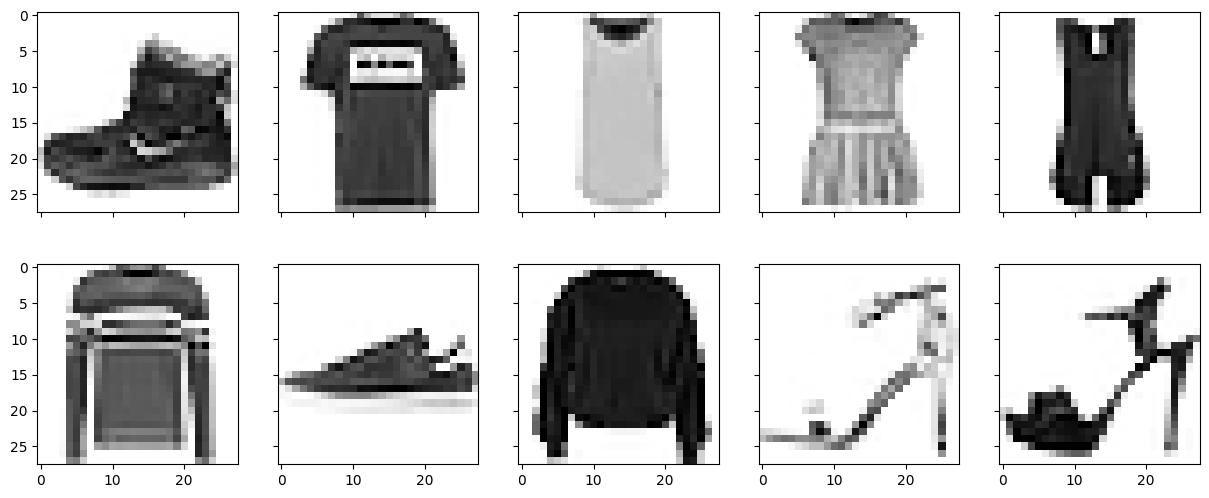

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=5,
                      sharex=True, sharey=True,
                      figsize=(15,6))

ax = ax.flatten()

for i in range(10):
  image = fashion_mnist_dataset[i][0].reshape(*image_size)
  ax[i].imshow((image+1)/2.0, cmap='Grays')

In [11]:
from torch.utils.data import DataLoader
batch_size = 64
fashion_mnist_dl = DataLoader(fashion_mnist_dataset, batch_size,
                              shuffle=True, drop_last=True)

In [12]:
num_epochs = 100
log = 10
model.train(num_epochs, log, dataloader=fashion_mnist_dl)

Epoch 10:
  G/D Loss: 0.8531/1.2945
  D-Real/D-Fake probs: 0.5447/0.4549

Epoch 20:
  G/D Loss: 0.7865/1.3412
  D-Real/D-Fake probs: 0.5250/0.4755

Epoch 30:
  G/D Loss: 0.7687/1.3465
  D-Real/D-Fake probs: 0.5223/0.4788

Epoch 40:
  G/D Loss: 0.7595/1.3559
  D-Real/D-Fake probs: 0.5161/0.4810

Epoch 50:
  G/D Loss: 0.7533/1.3535
  D-Real/D-Fake probs: 0.5184/0.4827

Epoch 60:
  G/D Loss: 0.7650/1.3493
  D-Real/D-Fake probs: 0.5225/0.4802

Epoch 70:
  G/D Loss: 0.7429/1.3610
  D-Real/D-Fake probs: 0.5153/0.4866

Epoch 80:
  G/D Loss: 0.7563/1.3520
  D-Real/D-Fake probs: 0.5203/0.4824

Epoch 90:
  G/D Loss: 0.7271/1.3720
  D-Real/D-Fake probs: 0.5091/0.4907

Epoch 100:
  G/D Loss: 0.7427/1.3589
  D-Real/D-Fake probs: 0.5162/0.4852



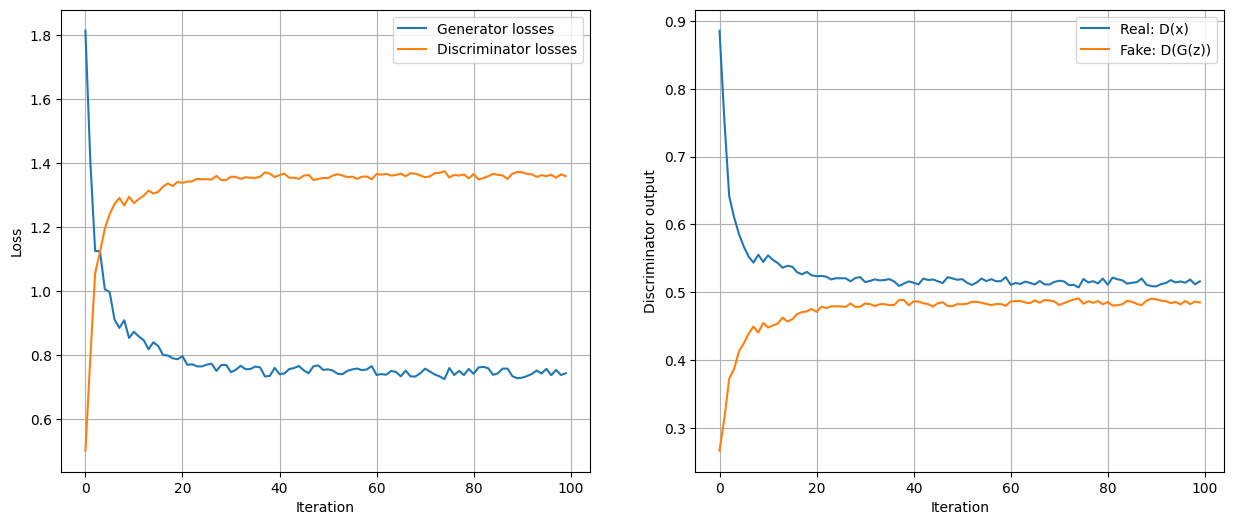

In [13]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
model.plot_loss_curve(ax1)
model.plot_disc_values_curve(ax2)

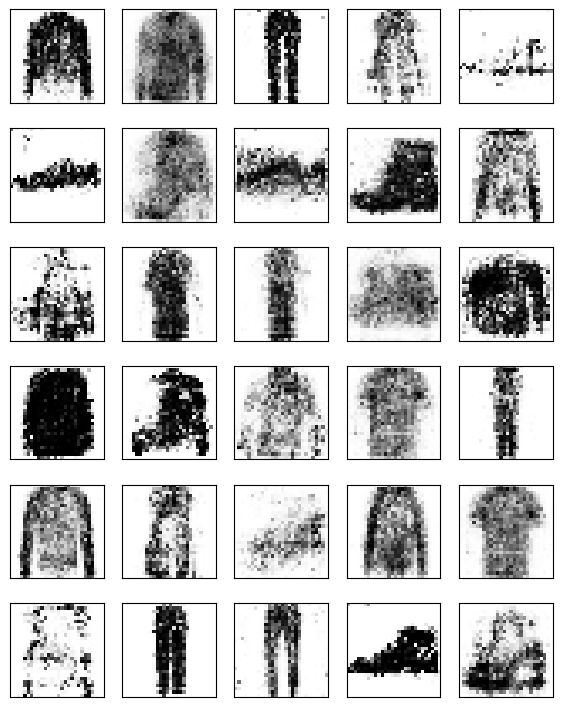

In [18]:
fig = plt.figure(figsize=(7, 9))
num_samples = 30
torch.manual_seed(10)
input_z = model.create_z(batch_size=num_samples, z_size=z_size, mode_z='normal').to(device)
generated_images = model.create_samples(input_z, image_size)
model.show_generated_samples(generated_images, fig)

In [19]:
torch.save(model, 'GAN_fashion_mnist.pth')

In [20]:
%%bash
jupyter nbconvert --to script 'GAN_fashion_mnist.ipynb'

[NbConvertApp] Converting notebook GAN_fashion_mnist.ipynb to script
[NbConvertApp] Writing 9284 bytes to GAN_fashion_mnist.py
